In [117]:
import pandas as pd

In [118]:
df = pd.read_csv("results/inference_time.csv")
df

,model,dataset,trial,inference_time,domain,num_variates,prediction_length,frequency
0,chronos_bolt_tiny,exchange_rate/short,0,0.038261,Econ/Fin,1,8,D
1,chronos_bolt_tiny,exchange_rate/short,1,0.044538,Econ/Fin,1,8,D
2,chronos_bolt_tiny,exchange_rate/short,2,0.038114,Econ/Fin,1,8,D
3,chronos_bolt_tiny,exchange_rate/short,3,0.040268,Econ/Fin,1,8,D
4,chronos_bolt_tiny,exchange_rate/short,4,0.039070,Econ/Fin,1,8,D
...,...,...,...,...,...,...,...,...
3695,timesfm1,jena_weather/H/long,5,0.845223,Nature,21,720,H
3696,timesfm1,jena_weather/H/long,6,0.878958,Nature,21,720,H
3697,timesfm1,jena_weather/H/long,7,0.850572,Nature,21,720,H
3698,timesfm1,jena_weather/H/long,8,0.858287,Nature,21,720,H


In [119]:
df.columns

Index(['model', 'dataset', 'trial', 'inference_time', 'domain', 'num_variates',
       'prediction_length', 'frequency'],
      dtype='object')

In [120]:
df = df.groupby(['model', 'dataset', 'domain', 'num_variates', 'prediction_length', 'frequency']).agg({
    "inference_time": "mean",
}).reset_index()

df

,model,dataset,domain,num_variates,prediction_length,frequency,inference_time
0,chronos_bolt_base,bitbrains_fast_storage/5T/long,Web/CloudOps,2,720,5T,526.805580
1,chronos_bolt_base,bitbrains_fast_storage/5T/medium,Web/CloudOps,2,480,5T,352.916874
2,chronos_bolt_base,bitbrains_fast_storage/5T/short,Web/CloudOps,2,48,5T,418.579793
3,chronos_bolt_base,bitbrains_fast_storage/H/short,Web/CloudOps,2,48,H,15.443538
4,chronos_bolt_base,bitbrains_rnd/5T/long,Web/CloudOps,2,720,5T,205.008266
...,...,...,...,...,...,...,...
347,timesfm1,solar/D/short,Energy,1,30,D,0.823982
348,timesfm1,solar/H/long,Energy,1,720,H,3.743754
349,timesfm1,solar/H/medium,Energy,1,480,H,2.577781
350,timesfm1,solar/H/short,Energy,1,48,H,6.056698


In [121]:
df["dataset"].unique()

array(['bitbrains_fast_storage/5T/long',
       'bitbrains_fast_storage/5T/medium',
       'bitbrains_fast_storage/5T/short',
       'bitbrains_fast_storage/H/short', 'bitbrains_rnd/5T/long',
       'bitbrains_rnd/5T/medium', 'bitbrains_rnd/5T/short',
       'bitbrains_rnd/H/short', 'bizitobs_application/10S/long',
       'bizitobs_application/10S/medium',
       'bizitobs_application/10S/short', 'bizitobs_l2c/5T/long',
       'bizitobs_l2c/5T/medium', 'bizitobs_l2c/5T/short',
       'bizitobs_l2c/H/long', 'bizitobs_l2c/H/medium',
       'bizitobs_l2c/H/short', 'bizitobs_service/10S/long',
       'bizitobs_service/10S/medium', 'bizitobs_service/10S/short',
       'dominick/long', 'dominick/medium', 'dominick/short', 'ercot/long',
       'ercot/medium', 'ercot/short', 'exchange_rate/long',
       'exchange_rate/medium', 'exchange_rate/short',
       'jena_weather/10T/long', 'jena_weather/10T/medium',
       'jena_weather/10T/short', 'jena_weather/D/short',
       'jena_weather/H/long', 

### Num. Samples + Time Series Len

In [122]:
import json
import numpy as np
from gift_eval.data import Dataset

In [123]:
datasets = pd.read_csv("results/data/dataset_pretty.csv")

In [124]:
pretty_names = {
    "jena_weather": "Jena Weather",
    "solar": "Solar",
    "bitbrains_fast_storage": "Bitbrains Fast Storage",
    "bitbrains_rnd": "Bitbrains RND",
    "bizitobs_l2c": "Bizitobs L2C",
    "bizitobs_application": "Bizitobs Application",
    "bizitobs_service": "Bizitobs Service",
}

In [125]:
short_datasets = "solar/10T solar/H solar/D solar/W jena_weather/10T jena_weather/H jena_weather/D " \
"bitbrains_fast_storage/5T bitbrains_fast_storage/H bitbrains_rnd/5T bitbrains_rnd/H bizitobs_application " \
"bizitobs_service bizitobs_l2c/5T bizitobs_l2c/H"

med_long_datasets = "solar/10T solar/H jena_weather/10T jena_weather/H " \
"bitbrains_fast_storage/5T bitbrains_rnd/5T bizitobs_application bizitobs_service bizitobs_l2c/5T bizitobs_l2c/H"

# Get union of short and med_long datasets
all_datasets = list(set(short_datasets.split() + med_long_datasets.split()))

dataset_properties_map = json.load(open("data/dataset_properties.json"))

In [126]:
def get_ts_length(ds_name, term):
    to_univariate = False  # Whether to convert the data to univariate
    dataset = Dataset(name=ds_name, term=term, to_univariate=to_univariate)

    ts_len = []
    rows = 0
    for x in dataset.test_data:
        s = x[0]["target"].shape
        if len(s) == 2:
            _, l = s
        else:
            _, l = 1, s[0]
        ts_len.append(l)
        rows += 1

    return np.average(np.array(ts_len)), rows

In [127]:
ts_len = {}
num_samples = {}

ds_name_map = {
    "bizitobs_application": "bizitobs_application/10S",
    "bizitobs_service": "bizitobs_service/10S"
}

for ds_name in all_datasets:
    for term in ["short", "medium", "long"]:
        if (
            term == "medium" or term == "long"
        ) and ds_name not in med_long_datasets.split():
            continue
        l, n = get_ts_length(ds_name, term)

        if ds_name in ["bizitobs_application", "bizitobs_service"]:
            ts_len[ds_name_map[ds_name]+"/"+term] = l
            num_samples[ds_name_map[ds_name]+"/"+term] = n
        else:
            ts_len[ds_name+"/"+term] = l
            num_samples[ds_name+"/"+term] = n

c:\Documenti\VS_Code\tesi\TSFM-ZeroShotEval\src\gift_eval\data.py:149: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = norm_freq_str(to_offset(self.freq).name)
c:\Documenti\VS_Code\tesi\TSFM-ZeroShotEval\src\gift_eval\data.py:149: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = norm_freq_str(to_offset(self.freq).name)
c:\Documenti\VS_Code\tesi\TSFM-ZeroShotEval\src\gift_eval\data.py:149: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  freq = norm_freq_str(to_offset(self.freq).name)


In [128]:
def get_ts_len_chronos(df):
    ts_len = []
    for e in df["target"]:
        ts_len.append(len(e))
    
    return np.average(np.array(ts_len))

In [129]:
from datasets import load_dataset

CHRONOS = "autogluon/chronos_datasets"
DATASET_CHRONOS = [
    "dominick",
    "ercot",
    "exchange_rate",
]

with open("data/chronos_dataset_properties.json") as f:
    dataset_properties_map = json.load(f)

for dataset in DATASET_CHRONOS:
    ds = load_dataset(CHRONOS, dataset, trust_remote_code=True)
    examples = [x for x in ds["train"]]
    temp_df = pd.DataFrame(examples)
    
    l = get_ts_len_chronos(temp_df)
    n = dataset_properties_map[dataset]["rows"]

    for term, c in zip(["short", "medium", "long"], [1, 10, 15]):
        ts_len[dataset+"/"+term] = l - c * dataset_properties_map[dataset]["prediction_length"]
        num_samples[dataset+"/"+term] = n

In [130]:
def add_avg_ts_len(x):
    return ts_len[x]

def add_num_samples(x):
    return num_samples[x]

df["time_series_avg_len"] = df["dataset"].apply(add_avg_ts_len)
df["num_samples"] = df["dataset"].apply(add_num_samples)
df

,model,dataset,domain,num_variates,prediction_length,frequency,inference_time,time_series_avg_len,num_samples
0,chronos_bolt_base,bitbrains_fast_storage/5T/long,Web/CloudOps,2,720,5T,526.805580,7560.0,2500
1,chronos_bolt_base,bitbrains_fast_storage/5T/medium,Web/CloudOps,2,480,5T,352.916874,7920.0,2500
2,chronos_bolt_base,bitbrains_fast_storage/5T/short,Web/CloudOps,2,48,5T,418.579793,8184.0,22500
3,chronos_bolt_base,bitbrains_fast_storage/H/short,Web/CloudOps,2,48,H,15.443538,649.0,2500
4,chronos_bolt_base,bitbrains_rnd/5T/long,Web/CloudOps,2,720,5T,205.008266,7560.0,1000
...,...,...,...,...,...,...,...,...,...
347,timesfm1,solar/D/short,Energy,1,30,D,0.823982,320.0,274
348,timesfm1,solar/H/long,Energy,1,720,H,3.743754,7680.0,274
349,timesfm1,solar/H/medium,Energy,1,480,H,2.577781,8040.0,274
350,timesfm1,solar/H/short,Energy,1,48,H,6.056698,8280.0,2603


In [131]:
df.columns

Index(['model', 'dataset', 'domain', 'num_variates', 'prediction_length',
       'frequency', 'inference_time', 'time_series_avg_len', 'num_samples'],
      dtype='object')

### Add indicators

In [132]:
df["normalized_inference_time"] = df["inference_time"] / (
    df["num_samples"] * df["prediction_length"]
)

In [133]:
df["normalized_time_per_input_output_point"] = (
    df["inference_time"] / (
        df["num_samples"] * df["prediction_length"] * df["time_series_avg_len"]
    )
)

### Analisi

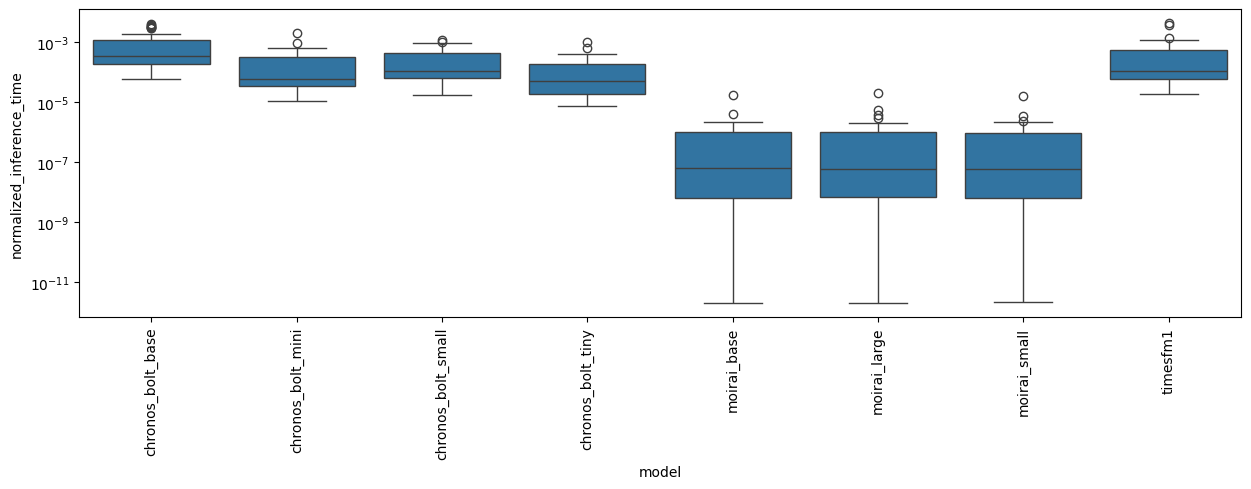

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
sns.boxplot(data=df, x="model", y="normalized_inference_time")
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()


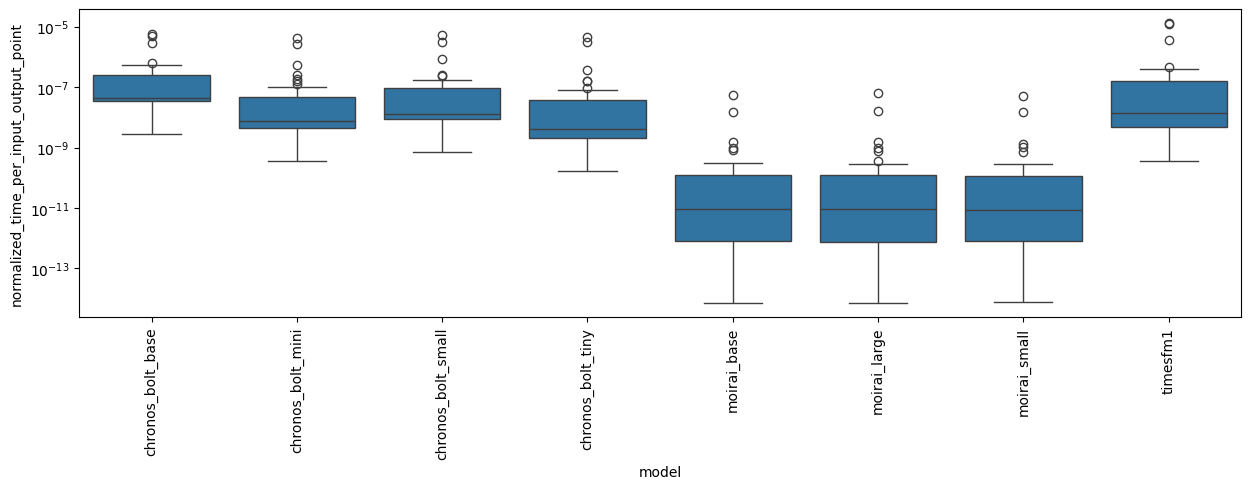

In [135]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, x="model", y="normalized_time_per_input_output_point")
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

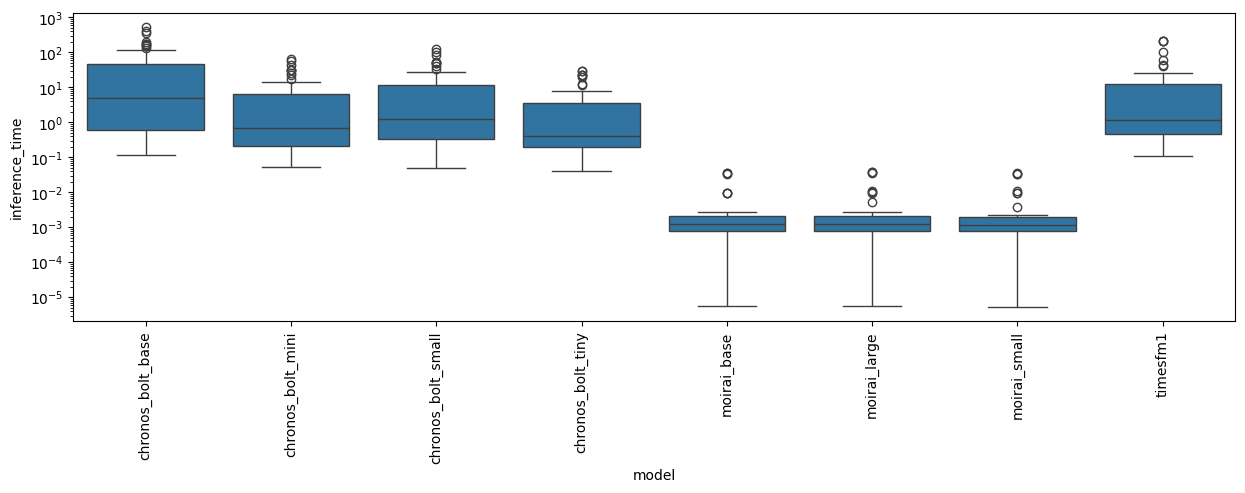

In [136]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, x="model", y="inference_time")
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

In [137]:
ranking = df.groupby("model")["inference_time"].mean().sort_values()
print(ranking)

model
moirai_small           0.003918
moirai_base            0.003973
moirai_large           0.004302
chronos_bolt_tiny      4.745163
chronos_bolt_mini      8.632092
chronos_bolt_small    15.754057
timesfm1              23.266848
chronos_bolt_base     62.077058
Name: inference_time, dtype: float64


In [138]:
df.groupby(["model"])["inference_time"].describe()


,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
chronos_bolt_base,44.0,62.077058,119.018577,0.113683,0.591222,5.006529,47.853905,526.805580
chronos_bolt_mini,44.0,8.632092,15.712591,0.053852,0.217192,0.678469,6.333999,63.621771
chronos_bolt_small,44.0,15.754057,29.145007,0.050961,0.337083,1.278440,11.437893,124.187846
chronos_bolt_tiny,44.0,4.745163,8.488335,0.039955,0.197271,0.398410,3.679251,29.391576
moirai_base,44.0,0.003973,0.008785,0.000006,0.000780,0.001240,0.002080,0.035765
moirai_large,44.0,0.004302,0.009444,0.000006,0.000763,0.001278,0.002130,0.038376
moirai_small,44.0,0.003918,0.008611,0.000005,0.000774,0.001137,0.001929,0.034859
timesfm1,44.0,23.266848,56.089719,0.111746,0.482523,1.146891,12.538156,215.736659


In [139]:
df.groupby(["model"])["normalized_time_per_input_output_point"].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
chronos_bolt_base,44.0,4.360648e-07,1.189337e-06,2.722099e-09,3.410401e-08,4.296503e-08,2.460268e-07,5.902525e-06
chronos_bolt_mini,44.0,2.032504e-07,7.504995e-07,3.486919e-10,4.471521e-09,7.466545e-09,4.878956e-08,4.212464e-06
chronos_bolt_small,44.0,2.558840e-07,9.349540e-07,7.012893e-10,8.842839e-09,1.331647e-08,9.331687e-08,5.442539e-06
chronos_bolt_tiny,44.0,2.008407e-07,8.015721e-07,1.680625e-10,2.154217e-09,4.232556e-09,3.712505e-08,4.443637e-06
moirai_base,44.0,1.685589e-09,8.340456e-09,7.223052e-15,7.874231e-13,9.539883e-12,1.252852e-10,5.354762e-08
moirai_large,44.0,1.947639e-09,9.980187e-09,7.061943e-15,7.361307e-13,9.200600e-12,1.273636e-10,6.477162e-08
moirai_small,44.0,1.561738e-09,7.691030e-09,7.679527e-15,7.873013e-13,8.863258e-12,1.142937e-10,4.929546e-08
timesfm1,44.0,7.415100e-07,2.714289e-06,3.629657e-10,4.638237e-09,1.369229e-08,1.595057e-07,1.312137e-05


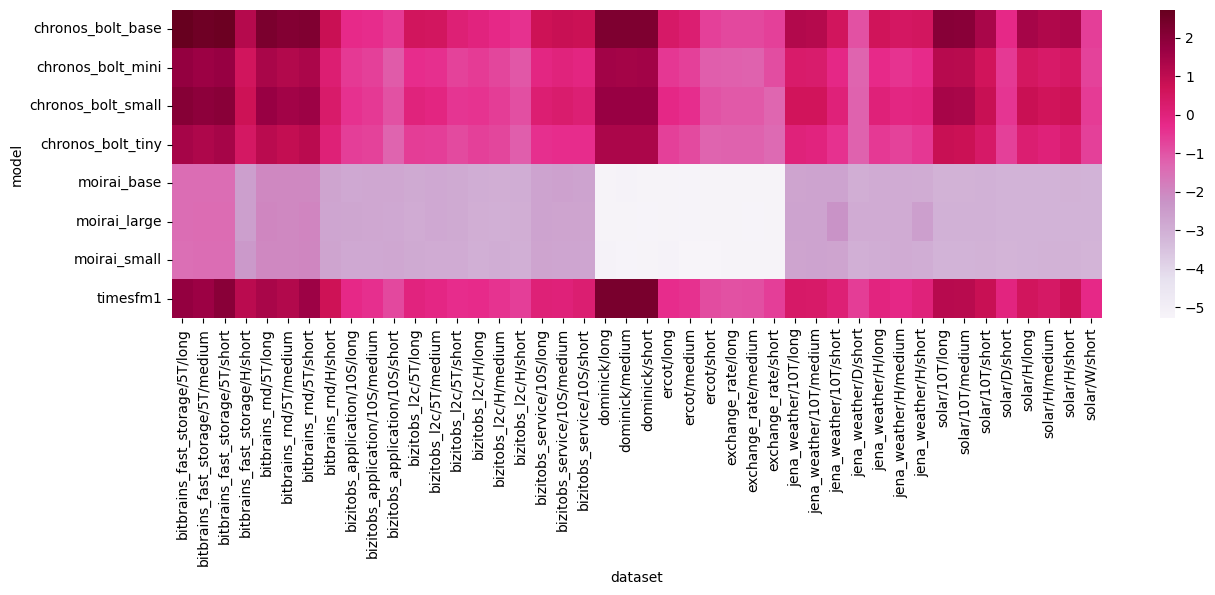

In [140]:
pivot = df.groupby(["dataset", "model"])["inference_time"].mean().unstack()
pivot_log = np.log10(pivot + 1e-9)

plt.figure(figsize=(15, 4))
sns.heatmap(pivot_log.T, cmap="PuRd", annot=False); # cmap="Pastel1"